In [1]:
# This part is the cross-sectional momentum strategy codes:

# Import relevant libraires and data from the API interface
import pandas as pd 
import numpy as np
from jqdata import * #API interface
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

startdate = (datetime.now() - timedelta(days=3000)).date()
end_date = datetime.now().date()

holding_period = 5
tdays = get_trade_days(start_date = startdate, end_date = end_date, count=None)
tdays = tdays[::holding_period]

constituents = ['IC8888.CCFX', 'IF8888.CCFX', 'IH8888.CCFX', 'IM8888.CCFX', 'T8888.CCFX', 'TF8888.CCFX', 'TS8888.CCFX',
               'SC8888.XINE', 'NR8888.XINE', 'LU8888.XINE', 'BC8888.XINE', 'EC8888.XINE', 'SH8888.XZCE', 'PX8888.XZCE',
               'AG8888.XSGE', 'AL8888.XSGE', 'AU8888.XSGE', 'BU8888.XSGE', 'CU8888.XSGE', 'FU8888.XSGE', 'HC8888.XSGE', 'NI8888.XSGE', 'PB8888.XSGE', 'RB8888.XSGE', 'RU8888.XSGE', 'SN8888.XSGE', 'WR8888.XSGE', 'ZN8888.XSGE', 'SP8888.XSGE', 'SS8888.XSGE', 
               'AP8888.XZCE', 'CF8888.XZCE', 'CY8888.XZCE', 'FG8888.XZCE', 'MA8888.XZCE', 'OI8888.XZCE', 'RS8888.XZCE', 'SF8888.XZCE', 'SM8888.XZCE', 'SR8888.XZCE', 'TA8888.XZCE', 'ZC8888.XZCE', 'CJ8888.XZCE', 'UR8888.XZCE', 'SA8888.XZCE', 'PF8888.XZCE', 'PK8888.XZCE',
               'A8888.XDCE', 'B8888.XDCE', 'BB8888.XDCE', 'C8888.XDCE', 'CS8888.XDCE', 'FB8888.XDCE', 'I8888.XDCE', 'J8888.XDCE', 'JD8888.XDCE', 'JM8888.XDCE', 'L8888.XDCE', 'M8888.XDCE', 'P8888.XDCE', 'PP8888.XDCE', 'V8888.XDCE', 'Y8888.XDCE', 'EG8888.XDCE', 'EB8888.XDCE', 'PG8888.XDCE', 'LH8888.XDCE', 'RR8888.XDCE',
               'SI8888.GFEX', 'BR8888.XSGE', 'AO8888.XSGE', 'TL8888.CCFX', 'LC8888.GFEX']

df = get_price(constituents, start_date = '2014-01-01', end_date = datetime.now().date(),
     fields=['money'], skip_paused=False, fq='pre', frequency = '1d', count=None)['money']


# Choose the top 70% contracts by trading volume 
def top_100_percent(row):
    sorted_row = sorted(row.dropna(), reverse=True)
    threshold_index = int(len(sorted_row) * 1)
    top_100_percent_values = sorted_row[:threshold_index]
    top_100_percent_columns = [col for val, col in zip(row, df.columns) if val in top_100_percent_values]
    
    return top_100_percent_columns

constituents_new = df.apply(top_100_percent, axis=1)


# To set the period of calculating the price increase & decrease percentage as three
N = [5]

daily_returns = pd.DataFrame(columns = N, index = tdays)

close_series = get_price(constituents, start_date= startdate ,
                         end_date= end_date,
          fields=['close'], skip_paused=False, fq='pre', frequency = '1d', count=None)['close']
open_series = get_price(constituents, start_date= startdate ,
                         end_date= end_date,
          fields=['open'], skip_paused=False, fq='pre', frequency = '1d', count=None)['open']

returns = close_series.pct_change()

entry_commission = 1/3000 * open_series
exit_commission = 1/3000 * close_series
futures_account_commission = (entry_commission + exit_commission) * 1/100
trading_cost = entry_commission + exit_commission + futures_account_commission
close_series_pct = (trading_cost / close_series).shift(-1*holding_period)

std = returns.rolling(window=holding_period).std()

# Calculate the series of price increase and decrease within 7 days
# Rank the commodity contracts based on their 7-day returns
returns_rank = returns.rank(axis=1)
total_rank = returns_rank.shape[1]

# Here we can generate some trading singals, top and bottom decimiles possess stronger signals
# Assuming that we have different levels of confidence in different contracts,
# we can trade more contracts with more obvious price increases and decreases

num_1 = 100 
num_2 = 10 
num_3 = 1

def long_or_short(rank):
    if  total_rank*2/10 < rank < total_rank*3/10:
        return - num_3 
    elif total_rank*1/10 < rank < total_rank*2/10:
        return - num_2
    elif 0 < rank < total_rank*1/10:
        return - num_1
    elif total_rank*7/10 < rank < total_rank*8/10:
        return num_3
    elif total_rank*8/10 < rank < total_rank*9/10:
        return num_2
    elif total_rank*9/10 < rank < total_rank:
        return num_1
    else:
        return 0

    return rank

signal = returns_rank.applymap(long_or_short)

#close_series_pct = close_series.pct_change(periods=holding_period)
holding_period_returns = returns.shift(-1*holding_period)
contract_correlation = holding_period_returns.corr()

# Set the correlation threshold and screen out high correlation pairs into a list
import math

correlation_threshold = 0.5
high_correlation_pairs = contract_correlation.stack().loc[lambda x: (x > correlation_threshold) & (x < 1)]
high_corr_pairs = high_correlation_pairs.index.tolist()

# For each day in 'signal', choose the weaker targets in high correlation paris and weaken their signals.
# Then choose the most approximate new weaker targets with the least aboslute return difference compared to the previsouly chosen weaker targets,
# and intensify the signals of the new weaker targets

for date in signal.index:
    for (item1, item2) in high_corr_pairs:
        if signal.at[date, item1] == num_1  and signal.at[date, item2] == num_1 :
            if holding_period_returns.at[date, item1] < holding_period_returns.at[date, item2]:
                signal.at[date, item1] = num_2
                for item in signal.columns.tolist():
                    if (item2, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.ceil(total_rank - (1/10 * total_rank)))):
                            signal.at[date, item] = num_1
            else:
                signal.at[date, item2] = num_2
                for item in signal.columns.tolist():
                    if (item1, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.ceil(total_rank - (1/10 * total_rank)))):
                            signal.at[date, item] = num_1
        
            if signal.at[date, item1] == -num_1 and signal.at[date, item2] == -num_1 :
                if holding_period_returns.at[date, item1] > holding_period_returns.at[date, item2]:
                    signal.at[date, item1] = -num_2
                    if (item2, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.floor(1 + (1/10 * total_rank)))):
                            signal.at[date, item] = -num_1
                else:
                    signal.at[date, item2] = -num_2
                    if (item1, item) not in high_corr_pairs:
                        if returns_rank.at[date, item] == min(returns_rank.loc[date], key=lambda x: abs(x - math.floor(1 + (1/10 * total_rank)))):
                            signal.at[date, item] = -num_1

# Sift contracts. For those with too low volatility, we screen them out
# Then we choose the commodity contracts within top decimiles 

for i, n in enumerate(N):
    past_N_days_returns = (close_series.shift(1) - close_series.shift(n+1)) / close_series.shift(n+1)
    for j, tday in enumerate(tdays):
        t = pd.Timestamp(tday) # Convert datetime.date to Timestamp objects
        pct_chg = past_N_days_returns[constituents_new[tday]].loc[t]
        pct_chg = pd.DataFrame({'PCT_CHG_PER': pct_chg})
        
        long = pct_chg.query('PCT_CHG_PER > 0').index.tolist()
        short = pct_chg.query('PCT_CHG_PER < 0').index.tolist()
        
        long_return = returns.loc[t][long]
        long_return = pd.DataFrame({'Returns': long_return})
        
        short_return = - returns.loc[t][short]
        short_return = pd.DataFrame({'Returns': short_return})
        
        t_cost = pd.DataFrame({'Trading Cost':close_series_pct.loc[t]})
        
        long_short_return = pd.concat([long_return, short_return])

        
        volatility = pd.DataFrame({'Volatility': std.loc[t]})
        signal_long = pd.DataFrame({'Signals': signal.loc[t][long]})
        signal_short = pd.DataFrame({'Signals': signal.loc[t][short]})
        
        signal_long_n_short = pd.concat([signal_long, signal_short])

        return_vol = pd.concat([long_short_return, volatility, signal_long_n_short], axis = 1).dropna()
        
        temp = ((1 / return_vol['Volatility'])* return_vol['Signals']).abs() # The inversion of volatility 
        
        return_vol['Weight'] = temp / temp.sum() # Weights
        
        daily_returns[n][tday] = ((return_vol['Returns'] - t_cost['Trading Cost']) * return_vol['Weight']).sum()

        # 计算当前进度
        progress = ((i * len(tdays)) + j + 1) / (len(N) * len(tdays)) * 100
        
        # 打印进度
        print(f'\rProgress: {progress:.1f}%', end='')



/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:168: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqresearch/api.py:120: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  round=round)
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:168: UserWarning: 不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），建议 get_price 传入 panel=False 参数
  warnings.warn("不建议继续使用panel（panel将在pandas未来版本不再支持，将来升级pandas后，您的策略会失败），"
/opt/conda/lib/python3.6/site-packages/jqdata/apis/data.py:168: UserWarni

Progress: 100.0%

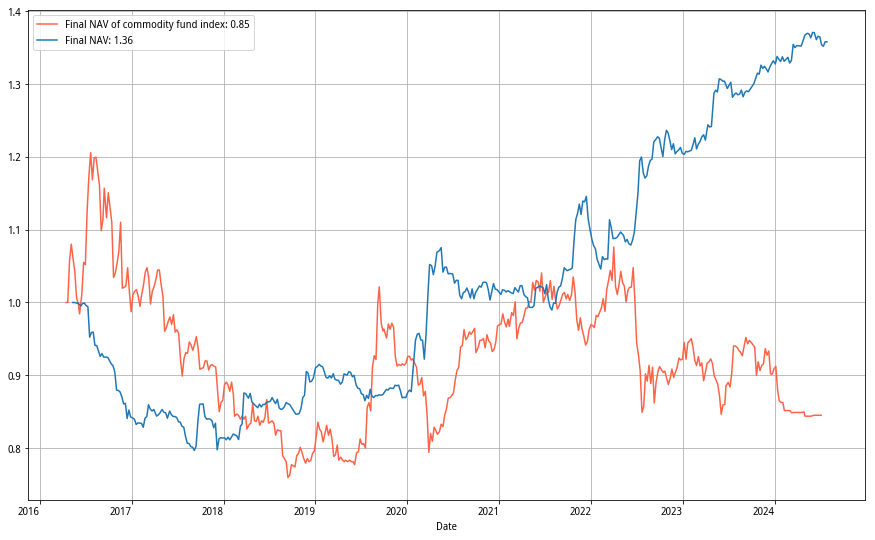

In [2]:
commodity_fund_idx = pd.read_excel('Commodity Fund Index.xlsx')
commodity_fund_idx.set_index(commodity_fund_idx.columns[0],inplace=True)
Z = [1]
for z in Z:
    commodity_fund_idx_chg = (commodity_fund_idx.shift(1) - commodity_fund_idx.shift(z+1)) / commodity_fund_idx.shift(z+1)

commodity_fund_idx_returns = commodity_fund_idx_chg.iloc[:,0].fillna(0) 


for n in N:

    daily_returns_new = daily_returns[n][-3000:] # Calculate the data from 3000 days ago

    # Calculate the net asset value

    annual_return = daily_returns_new.mean() * 252 # 计算年化收益率
    daily_std = daily_returns_new.std() * np.sqrt(252) # 计算波动率
    sharpe_ratio = annual_return / daily_std # 计算夏普
    net_asset_value = (daily_returns_new + 1).cumprod() #计算基金净值

    # 绘制净值曲线
    (commodity_fund_idx_returns+1).cumprod(axis=0).plot(grid=True, color='tomato',label='Final NAV of commodity fund index: {:.2f}'.format((commodity_fund_idx_returns+1).prod()))
    net_asset_value.plot(figsize = (15,10), grid = True, label='Final NAV: {:.2f}'.format((daily_returns_new + 1).prod()))
# 添加图例
plt.legend()

# 显示图
plt.show()